## Homophilic Barabási-Albert model

In this notebook we can find our implementation of the network formation model described in [Karimi et al., 2018]. This model was implemented for a better understanding of the model as part of the Final Degree Project.

[Karimi et al., 2018] Karimi, F., G ́enois, M., Wagner, C., Singer, P., and
Strohmaier, M. (2018). Homophily influences ranking of minorities in social
networks. Scientific reports, 8(1):1–12.

### Content

* [Imports](#chapter1)
* [Utils](#chapter2)
* [Model implementation](#chapter3)
* [Analysis of the model](#chapter4)
    * [Experiment 1. Effect of $h$](#section_4_1)
        * [Example](#section_4_1_1)
        * [Class degree](#section_4_1_2)
        * [Degree distribution](#section_4_1_3)
    * [Experiment 2. Effect of $C_0$ and $C_1$](#section_4_2)
        * [Example](#section_4_1_2)
* [Analysis of the model](#chapter4)
* [Graph example](#chapter5)

### Imports <a class="anchor" id="chapter1"></a>

In [4]:
import numpy as np
import networkx as nx
import statistics
import math
import random
from collections import Counter
import matplotlib.pyplot as plt

### Utils <a class="anchor" id="chapter2"></a>

In [5]:
## Utils functions

def flatten(t):
    
    """
    e.g. [[1, 2, 3], [4, 5, 6]] --> [1, 2, 3, 4, 5, 6]
    """
    
    return [item for sublist in t for item in sublist]

def fix_probabilities(p):
    
    """
    Simple function to deal with numeric errors.
    If a probability is negative, assign it to 0.

    Parameters:
        p: List of probabilities.
    """
    
    for i in range(len(p)):
        if p[i] < 0:
            p[i] = 0
            
    return p

### Model implementation <a class="anchor" id="chapter3"></a>

In [6]:
def homophilic_barabasi_albert(n, m, m0, c0, h):
    
    """
    Our custom model.
    
    Parameters:
        n: Number of nodes of the output graph
        m: Edges attached to the new node in each step
        c0: Probability of a node to belong to the majority class
        h: Homophily
    """   
        
    # Probability of a node to belong to the minority class
    c1 = 1 - c0
    
    # c[0] = set of nodes in the majority class
    # c[1] = set of nodes in the minority class
    c = [set(), set()]    
    
    # Assign random classes to the first m0 nodes
    for i in range(m0):
        class_i = np.random.choice([0, 1], p=[c0, c1])
        c[class_i].add(i)
    
    # Create the initial graph
    G = nx.empty_graph(m0)
    G.name="homophilic_barabasi_albert_graph(%s,%s,%s,%s,%s)"%(n, m, m0, c0, h)
    
    # Next node to be added (We have already added nodes 0, 1, ..., m0 - 1)
    i = m0
    while G.number_of_nodes() < n:
        
        # Assign a class to the new node (node i)
        class_i = np.random.choice([0, 1], p=[c0, c1])
        c[class_i].add(i)
        
        nodes_degree = G.degree()
        
        nodes = np.array([node for node, degree in nodes_degree])
        degrees = np.array([degree if degree > 0 else 1 for node, degree in nodes_degree])
        
        probs = []
        for j in range(len(nodes)):
            
            # Get the class of the corresponding node
            if nodes[j] in c[0]:
                class_j = 0
            else:
                class_j = 1
            
            # Compute the probability adding an edge between this two nodes
            if class_i == class_j:
                probs.append( h*degrees[j] )
            else:
                probs.append( (1-h)*degrees[j] )
        probs = np.array(probs)
                
        neighbours = []
        idx_candidates = probs.nonzero()
        nodes = nodes[idx_candidates]
        probs = probs[idx_candidates]
        
        # Keep only candidate nodes to be attached
        if len(nodes) < m:
            neighbours = nodes
        else:
            probs = probs / probs.sum()
            n_new_edges = min(m, (probs > 0).sum())
            neighbours = np.random.choice(nodes, replace=False, size=n_new_edges, p=probs)
            
        # Add the new node
        G.add_node(i)
        
        # Add the m edges
        for neighbour in neighbours:
            G.add_edge(i, neighbour)
     
        i += 1
    
    c[0] = list(c[0])
    c[1] = list(c[1])
    
    return G, c

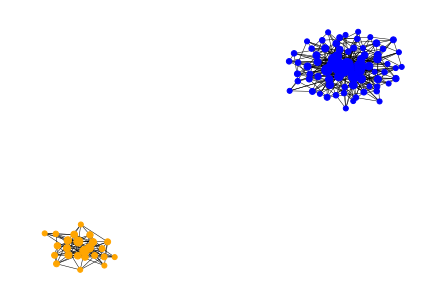

In [18]:
# Test our model
G, c = homophilic_barabasi_albert(n=100, m=5, m0=5, c0=0.8, h=1)

node_color = ['blue' if node in c[0] else 'orange' for node in G.nodes]
node_size = np.array(list(dict(G.degree()).values())) * 5
nx.draw(G, node_color=node_color, node_size=node_size, width=0.5)
plt.show()

## Analysis of the model <a class="anchor" id="chapter4"></a>

In [19]:
base_colors = ['orange', 'blue']

In [20]:
def compute_simulation(n=5000, m=5, m0=5, c0=0.5, h=0.5, n_simulations=1):
    
    """
    Run n simulation of the model with the defined parameters. Return the last created graph and 
    a list of lists, with te degrees of the nodes in each of the two classes.

    Save in the specified directory a list with each of the graphs generated and a list with the
    class of each node in each of the executions.

    Parameters:
        n: Number of nodes of the output graph.
        m: Edges attached to the new node in each step.
        c0: Probability of a node to belong to the majority class.
        c1: Probability of a node to belong to the minority class.
        h: Homophily parameter, where h=1 corresponds to a completely homophilic network and h=0
            corresponds to a completely homophilic network.
        n_simulations: Number of simulations of the experiment.
    """
    
    degrees_majority = []
    degrees_minority = []
    
    for i in range(n_simulations):
        G, c = homophilic_barabasi_albert(n, m, m0, c0, h)
        nodes_degree = G.degree()
        
        d_majority = sorted([degree for node, degree in nodes_degree if node in c[0]])
        d_minority = sorted([degree for node, degree in nodes_degree  if node in c[1]])
        
        degrees_majority.append(d_majority)
        degrees_minority.append(d_minority)
        
    return G, degrees_majority, degrees_minority

### Experiment 1. Effect of $h$ <a class="anchor" id="section_4_1"></a>

#### Exemples <a class="anchor" id="section_4_1_1"></a>

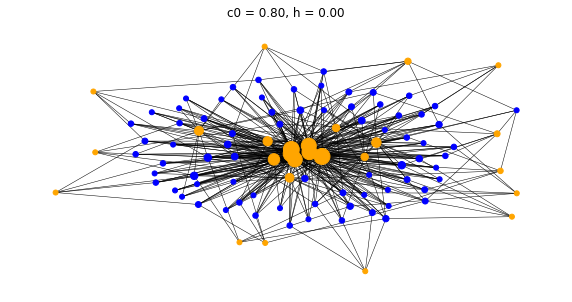

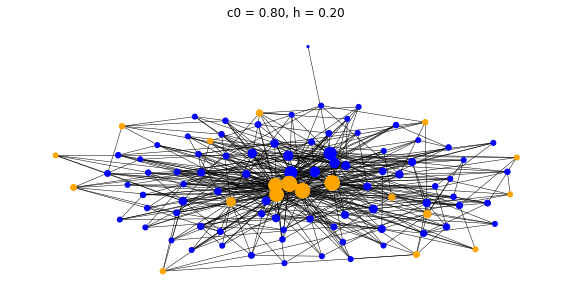

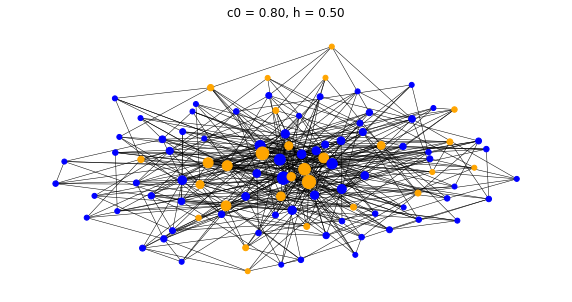

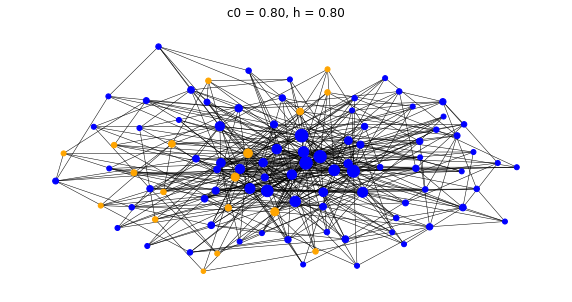

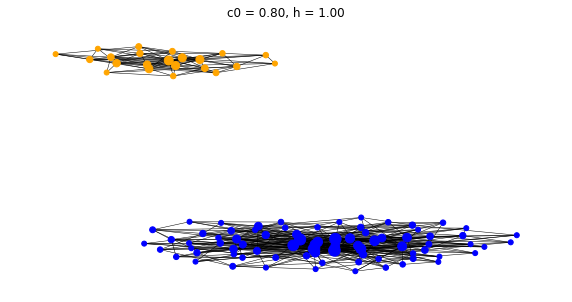

In [23]:
n = 100
m = 5
m0 = 5
c0 = 0.8
c1 = 1 - c0
h = [0, 0.2, 0.5, 0.8, 1]

for i in range(len(h)):
    G, c = homophilic_barabasi_albert(n, m, m0, c0, h[i])    
    
    plt.figure(figsize=(10,5))
    ax = plt.gca()
    ax.set_title('c0 = %.2f, h = %.2f' % (c0, h[i]))
    node_color = ['blue' if node in c[0] else 'orange' for node in G.nodes]
    node_size = np.array(list(dict(G.degree()).values())) * 5
    nx.draw(G, node_color=node_color, node_size=node_size, width=0.5)
    plt.show()

The execution of the cell below may require a lot of time, depending on the $n$ value.

In [25]:
# Get all the data for the next plots
n = 500
m = 5
m0 = 5
c0 = 0.8
c1 = 1 - c0
h = [0, 0.2, 0.5, 0.8, 1]
n_simulations = 20

avg_degree_majority = []
avg_degree_minority = []

degree_majority_sample = []
degree_minority_sample = []

degree_dist_majority = []
degree_dist_minority = []

for i in range(len(h)):
    
    ## Get the degrees of the simulations
    _, degrees_majority, degrees_minority = compute_simulation(n=n, m=m, m0=m0, c0=c0,
                                                               h=h[i], n_simulations=n_simulations)
    
    ## Estimate the average degree of each class
    k_majority = []
    k_minority = []
    
    # For each simulation, compute the percentage of links captured from each class
    for j in range(n_simulations):
        k = sum(degrees_majority[j]) + sum(degrees_minority[j])
        k_majority.append( sum(degrees_majority[j]) / k)
        k_minority.append( sum(degrees_minority[j]) / k)
        
    # Estimate the % of links captured by each class as the mean of each simulation
    avg_degree_majority.append(statistics.mean(k_majority))
    avg_degree_minority.append(statistics.mean(k_minority))
    
    ##Data for the degree distribution plot
    
    # For the majority class
    degrees_majority = flatten(degrees_majority)
    max_majority = max(degrees_majority)
    ctr_max = Counter(degrees_majority)
    
    data_majority = [ctr_max[i] if i in ctr_max else 0 for i in range(max_majority)]
    degree_dist_majority.append(data_majority)
    
    # For the majority class
    degrees_minority = flatten(degrees_minority)
    max_minority = max(degrees_minority)
    ctr_max = Counter(degrees_minority)
    
    data_minority = [ctr_max[i] if i in ctr_max else 0 for i in range(max_minority)]
    degree_dist_minority.append(data_minority)

#### Class degree <a class="anchor" id="section_4_1_2"></a>

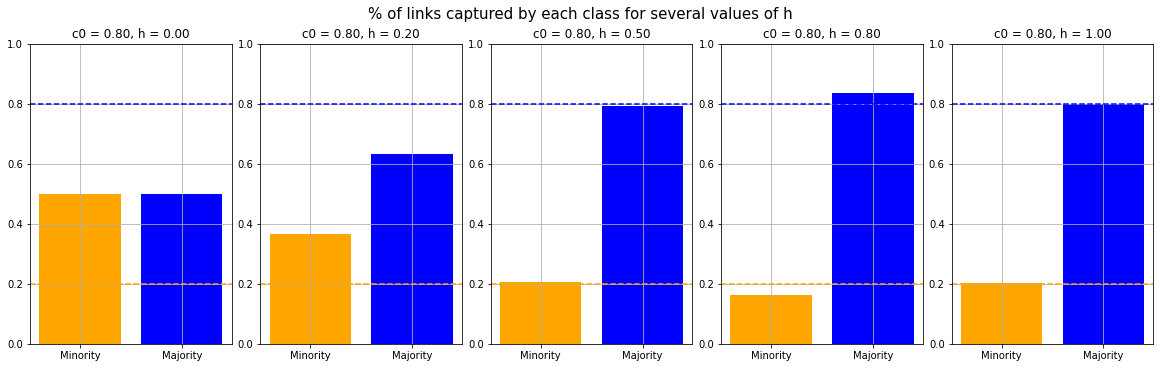

In [27]:
# Average degree barplot
fig, axes = plt.subplots(1, len(h), figsize=(16, 5), constrained_layout=True)
fig.suptitle('% of links captured by each class for several values of h', fontsize=15)

for i in range(len(h)):
    x = ['Minority', 'Majority']
    y = [avg_degree_minority[i], avg_degree_majority[i]]
    axes[i].bar(x,y, color=base_colors)
    axes[i].set_title('c0 = %.2f, h = %.2f' % (c0, h[i]))
    axes[i].set_ylim(0.0, 1.0)
    # Reference lines
    axes[i].axhline(c0, linestyle='--', color='b')
    axes[i].axhline(c1, linestyle='--', color='orange')
    axes[i].grid()
    
plt.show()

#### Explanation

In all cases, the probability of a node to belong to the majority class is 80%. What we change across the several is the homophily parameter.

In the y-axis, we see the sum of the degree of all nodes of each class, divided by the sum of all node degrees.

#### Degree distribution <a class="anchor" id="section_4_1_3"></a>

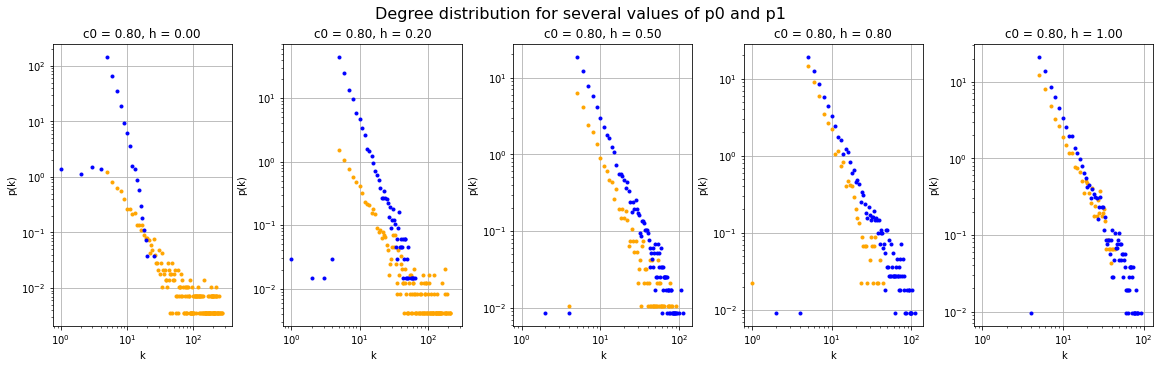

In [28]:
# Degree distribution plot
fig, axes = plt.subplots(1, 5, figsize=(16, 5), constrained_layout=True)
fig.suptitle('Degree distribution for several values of p0 and p1', fontsize=16)

for i in range(len(h)):
    # Plot the dist. of the minority class
    degree_hist = np.array(degree_dist_minority[i], dtype=float)
    degree_prob = degree_hist / len(degree_dist_minority[i])
    axes[i].loglog(np.arange(degree_prob.shape[0]),degree_prob,'.', color=base_colors[0])
    
    # Plot the dist. of the majority class
    degree_hist = np.array(degree_dist_majority[i], dtype=float)
    degree_prob = degree_hist / len(degree_dist_majority[i])
    axes[i].loglog(np.arange(degree_prob.shape[0]),degree_prob,'.', color=base_colors[1])
    
    axes[i].set_title('c0 = %.2f, h = %.2f' % (c0, h[i]))
    axes[i].grid()
    axes[i].set_xlabel('k')
    axes[i].set_ylabel('p(k)')

#### Explanation

In all cases, the probability of a node to belong to the majority class is 80%. What we change across the several executions of the model is the probability of a node to have a preference for majority or minority nodes (p0 and p1 respectively).

x-axis: Degree of a node.

y-axis: Probability of sampling a node at random with that degree from the graph.

For each case, we see the degree distribution for a particular graph. For a more rigorous analysis, results must be averaged across all the experiments.

### Experiment 2. Effect of $C_0$ and $C_1$ <a class="anchor" id="section_4_2"></a>

#### Example <a class="anchor" id="section_4_2_1"></a>

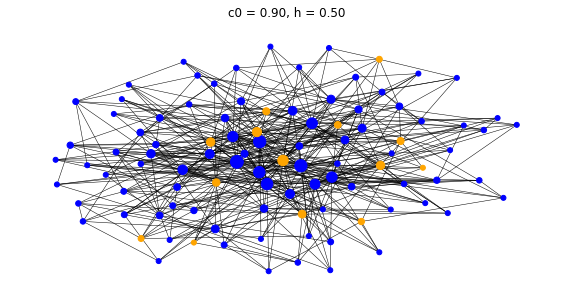

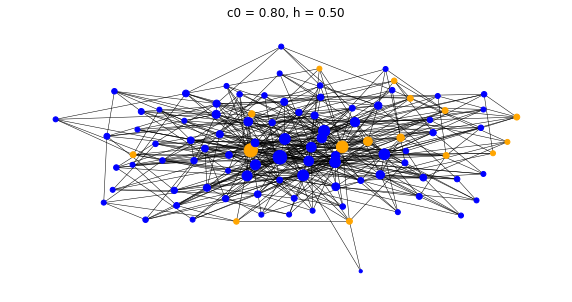

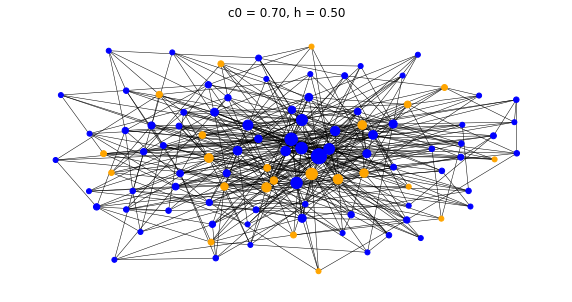

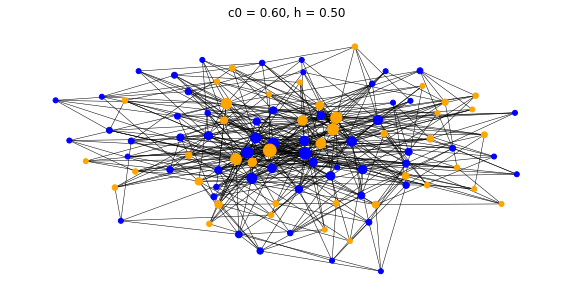

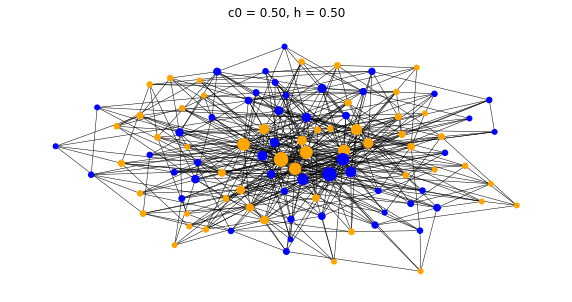

In [31]:
## Plot sample graphs
n = 100
m = 5
m0 = 5
c0 = [0.9, 0.8, 0.7, 0.6, 0.5]
c1 = [1 - p for p in c0]
h = 0.5

for i in range(len(c0)):
    G, c = homophilic_barabasi_albert(n, m, m0, c0[i], h)
    
    plt.figure(figsize=(10,5))
    ax = plt.gca()
    ax.set_title('c0 = %.2f, h = %.2f' % (c0[i], h))
    node_color = ['blue' if node in c[0] else 'orange' for node in G.nodes]
    node_size = np.array(list(dict(G.degree()).values())) * 5
    nx.draw(G, node_color=node_color, node_size=node_size, width=0.5)
    plt.show()

In [32]:
# Get all the data for the next plots
n = 500
m = 5
m0 = 5
c0 = [0.9, 0.8, 0.7, 0.6, 0.5]
c1 = [1 - p for p in c0]
h = 0.5
n_simulations = 20

avg_degree_majority = []
avg_degree_minority = []

degree_majority_sample = []
degree_minority_sample = []

degree_dist_majority = []
degree_dist_minority = []

for i in range(len(c0)):
    
    ## Get the degrees of the simulations
    _, degrees_majority, degrees_minority = compute_simulation(n=n, m=m, m0=m0, c0=c0[i],
                                                               h=h, n_simulations=n_simulations)
    
    ## Estimate the average degree of each class
    k_majority = []
    k_minority = []
    
    # For each simulation, compute the percentage of links captured from each class
    for j in range(n_simulations):
        k = sum(degrees_majority[j]) + sum(degrees_minority[j])
        k_majority.append( sum(degrees_majority[j]) / k)
        k_minority.append( sum(degrees_minority[j]) / k)
        
    # Estimate the % of links captured by each class as the mean of each simulation
    avg_degree_majority.append(statistics.mean(k_majority))
    avg_degree_minority.append(statistics.mean(k_minority))
    
    ##Data for the degree distribution plot
    
    # For the majority class
    degrees_majority = flatten(degrees_majority)
    max_majority = max(degrees_majority)
    ctr_max = Counter(degrees_majority)
    
    data_majority = [ctr_max[i] if i in ctr_max else 0 for i in range(max_majority)]
    degree_dist_majority.append(data_majority)
    
    # For the majority class
    degrees_minority = flatten(degrees_minority)
    max_minority = max(degrees_minority)
    ctr_max = Counter(degrees_minority)
    
    data_minority = [ctr_max[i] if i in ctr_max else 0 for i in range(max_minority)]
    degree_dist_minority.append(data_minority)

#### Class degree <a class="anchor" id="section_4_2_2"></a>

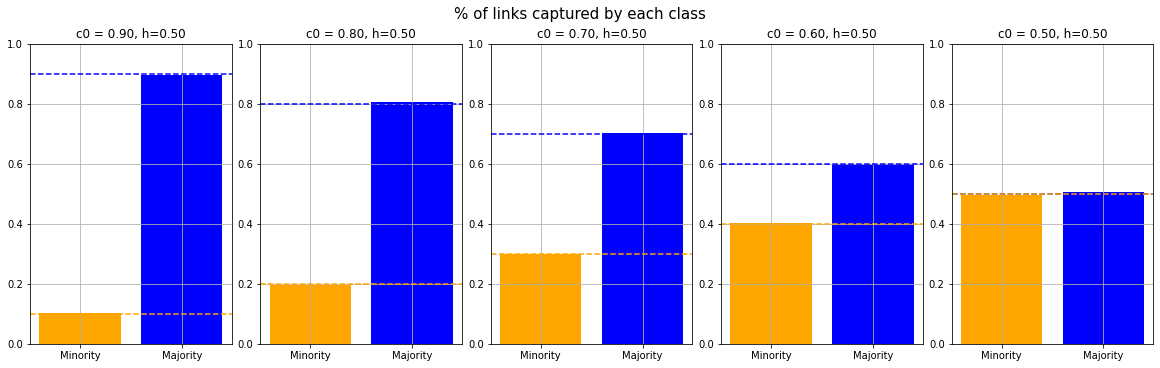

In [35]:
# Average degree barplot
fig, axes = plt.subplots(1, 5, figsize=(16, 5), constrained_layout=True)
fig.suptitle('% of links captured by each class', fontsize=15)

for i in range(5):
    x = ['Minority', 'Majority']
    y = [avg_degree_minority[i], avg_degree_majority[i]]
    axes[i].bar(x, y, color=base_colors)
    axes[i].set_title('c0 = %.2f, h=%.2f' % (c0[i], h))
    axes[i].set_ylim(0.0, 1.0)
    # Reference lines
    axes[i].axhline(c0[i], linestyle='--', color='b')
    axes[i].axhline(c1[i], linestyle='--', color='orange')
    axes[i].grid()
    
plt.show()

#### Explanation

In all cases, the probability of a node to belong to the majority class is 80%. What we change across the several executions of the model is the probability of a node to have a preference for majority or minority nodes (p0 and p1 respectively).

In the y-axis, we see the sum of the degree of all nodes of each class, divided by the sum of all node degrees.

#### Degree distribution <a class="anchor" id="section_4_2_3"></a>

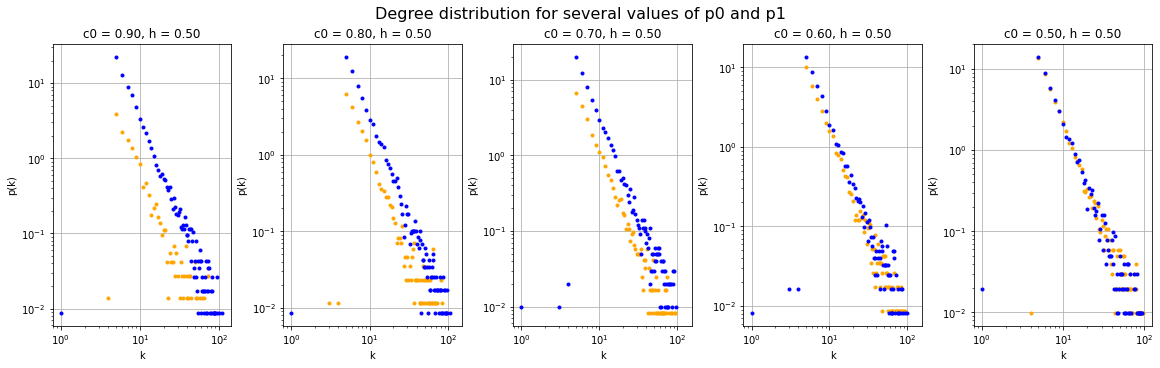

In [36]:
# Degree distribution plot
fig, axes = plt.subplots(1, 5, figsize=(16, 5), constrained_layout=True)
fig.suptitle('Degree distribution for several values of p0 and p1', fontsize=16)

for i in range(5):
    # Plot the dist. of the minority class
    degree_hist = np.array(degree_dist_minority[i], dtype=float)
    degree_prob = degree_hist / len(degree_dist_minority[i])
    axes[i].loglog(np.arange(degree_prob.shape[0]),degree_prob,'.', color=base_colors[0])
    
    # Plot the dist. of the majority class
    degree_hist = np.array(degree_dist_majority[i], dtype=float)
    degree_prob = degree_hist / len(degree_dist_majority[i])
    axes[i].loglog(np.arange(degree_prob.shape[0]),degree_prob,'.', color=base_colors[1])
    
    axes[i].set_title('c0 = %.2f, h = %.2f' % (c0[i], h))
    axes[i].grid()
    axes[i].set_xlabel('k')
    axes[i].set_ylabel('p(k)')

### Experiment 3. Minority in top d% degree rank <a class="anchor" id="section_5_3"></a>

In [38]:
def compute_simulation_2(n=5000, m=5, m0=5, c0=0.5, h=0.5, n_simulations=1):
    
    """
    Same as compute_simulation function. The difference is that it return a matrix M s.t. 
    M[i,j] = # nodes of the minority class in the top j nodes with larger degree in the i-th simultation.
    """
    
    sorted_degree_per_class = np.zeros((n_simulations, n))
    
    for i in range(n_simulations):
        G, c = homophilic_barabasi_albert(n, m, m0, c0, h)
        
        node_degree = sorted( dict(G.degree()).items(), key=lambda item: item[1], reverse=True)
        
        # degree_per_class = 0 if the class of the i-th node (0-based) with largest degree is of the majority class
        # 1 otherwise
        degree_per_class = np.array([0 if nd[0] in c[0] else 1 for nd in node_degree])
        sorted_degree_per_class[i:,] = degree_per_class
        
    return G, sorted_degree_per_class

In [39]:
n = 500
m = 5
m0 = 5
c0 = 0.8
c1 = 1 - c0
h = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1]
n_simulations = 10

step = list(np.linspace(0, 1, 11))[1:]

results = np.zeros((len(h), len(step)))

for i in range(len(h)):
    _, sorted_degree_per_class = compute_simulation_2(n=n, m=m, m0=m0, c0=c0, h=h[i],
                                                               n_simulations=n_simulations)
    
    sorted_degree_per_class = np.cumsum(sorted_degree_per_class, axis=1).mean(axis=0)

    for j in range(len(step)):
        pass
        results[i, j] = sorted_degree_per_class[math.floor(step[j]*n) - 1] / math.floor(step[j] * n)

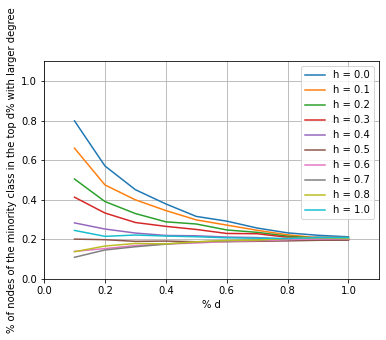

In [40]:
for i in range(len(h)):
    plt.plot(step, results[i,:])

plt.xlabel("% d")
plt.ylabel("% of nodes of the minority class in the top d% with larger degree")
plt.legend(["h = %.1f" % h[i] for i in range(len(h))])
plt.axis([0, 1.1, 0, 1.1])
plt.grid()

#### Explanation

For several preferences, we can see the percentage of nodes in the minority class in the top d% with highest degree. In all cases, c0 = 0.8.

The graphic is different than the one in [Karimi et al., 2018], but we are using a smaller value of $n$.